In [5]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Define transformations for the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize to range [-1, 1]
])

# Download and prepare the MNIST training and test sets
train_data = datasets.MNIST(root='mnist_data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='mnist_data', train=False, download=True, transform=transform)

# Create DataLoaders for training and testing
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


In [6]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [7]:
def train_standard(model, criterion, optimizer, epochs=5):
    model.train()
    accuracy_list = []
    for epoch in range(epochs):
        total, correct = 0, 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        accuracy_list.append(accuracy)
        print(f'Epoch [{epoch+1}/{epochs}], Accuracy: {accuracy:.2f}%')
    return accuracy_list


In [10]:
def train_continual(model, criterion, optimizer, epochs=5, replacement_rate=0.2, maturity_threshold=10):
    model.train()
    accuracy_list = []
    utility1, utility2 = torch.zeros(256), torch.zeros(128)  # Utility tracking for features in fc1 and fc2
    age1, age2 = torch.zeros(256), torch.zeros(128)          # Age of each feature in fc1 and fc2

    def replace_features(layer, utility, age, num_replacements):
        lowest_util_indices = utility.argsort()[:num_replacements]
        for i in lowest_util_indices:
            layer.weight.data[i, :] = torch.randn(layer.weight.shape[1]) * 0.01  # Reinitialize row i
            utility[i] = 0  # Reset utility for the replaced feature
            age[i] = 0      # Reset age for the replaced feature


    for epoch in range(epochs):
        total, correct = 0, 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update utility and age for hidden layers
            hidden_output1 = torch.relu(model.fc1(images.view(-1, 28 * 28)))
            hidden_output2 = torch.relu(model.fc2(hidden_output1))

            utility1 += torch.abs(hidden_output1.mean(dim=0))
            utility2 += torch.abs(hidden_output2.mean(dim=0))
            age1 += 1
            age2 += 1

        if epoch % maturity_threshold == 0:
            replace_features(model.fc1, utility1, age1, int(replacement_rate * 256))
            replace_features(model.fc2, utility2, age2, int(replacement_rate * 128))

        accuracy = 100 * correct / total
        accuracy_list.append(accuracy)
        print(f'Epoch [{epoch+1}/{epochs}], Accuracy: {accuracy:.2f}%')
    return accuracy_list


Training standard backprop model:
Epoch [1/10], Accuracy: 73.67%
Epoch [2/10], Accuracy: 89.20%
Epoch [3/10], Accuracy: 90.77%
Epoch [4/10], Accuracy: 91.73%
Epoch [5/10], Accuracy: 92.52%
Epoch [6/10], Accuracy: 93.17%
Epoch [7/10], Accuracy: 93.67%
Epoch [8/10], Accuracy: 94.30%
Epoch [9/10], Accuracy: 94.69%
Epoch [10/10], Accuracy: 95.22%

Training continual backprop model:
Epoch [1/10], Accuracy: 75.35%
Epoch [2/10], Accuracy: 89.25%
Epoch [3/10], Accuracy: 90.88%
Epoch [4/10], Accuracy: 91.85%
Epoch [5/10], Accuracy: 92.64%
Epoch [6/10], Accuracy: 93.34%
Epoch [7/10], Accuracy: 94.00%
Epoch [8/10], Accuracy: 94.49%
Epoch [9/10], Accuracy: 95.02%
Epoch [10/10], Accuracy: 95.35%


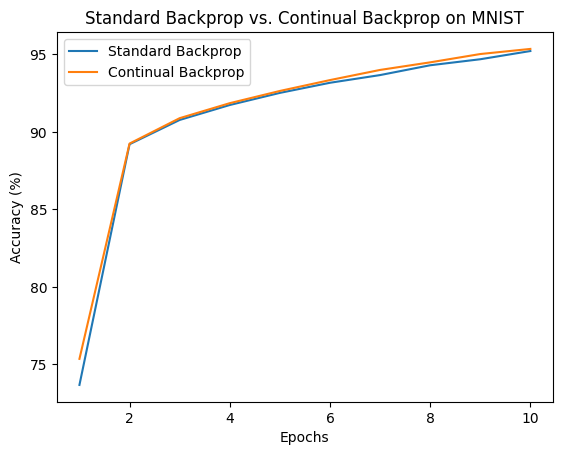

In [11]:
# Initialize models, criterion, and optimizer
model_standard = SimpleNet()
model_continual = SimpleNet()
criterion = nn.CrossEntropyLoss()
optimizer_standard = optim.SGD(model_standard.parameters(), lr=0.01)
optimizer_continual = optim.SGD(model_continual.parameters(), lr=0.01)

# Train both models
print("Training standard backprop model:")
acc_standard = train_standard(model_standard, criterion, optimizer_standard, epochs=10)

print("\nTraining continual backprop model:")
acc_continual = train_continual(model_continual, criterion, optimizer_continual, epochs=10)

# Plot the results
plt.plot(range(1, 11), acc_standard, label='Standard Backprop')
plt.plot(range(1, 11), acc_continual, label='Continual Backprop')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Standard Backprop vs. Continual Backprop on MNIST')
plt.legend()
plt.show()


Training standard backprop model on Permuted MNIST:
Epoch [1/10], Accuracy: 13.38%
Epoch [2/10], Accuracy: 18.02%
Epoch [3/10], Accuracy: 20.16%
Epoch [4/10], Accuracy: 20.29%
Epoch [5/10], Accuracy: 20.66%
Epoch [6/10], Accuracy: 20.83%
Epoch [7/10], Accuracy: 20.94%
Epoch [8/10], Accuracy: 20.66%
Epoch [9/10], Accuracy: 20.97%
Epoch [10/10], Accuracy: 21.02%

Training continual backprop model on Permuted MNIST:
Epoch [1/10], Accuracy: 12.50%
Epoch [2/10], Accuracy: 16.54%
Epoch [3/10], Accuracy: 18.99%
Epoch [4/10], Accuracy: 19.65%
Epoch [5/10], Accuracy: 19.85%
Epoch [6/10], Accuracy: 20.22%
Epoch [7/10], Accuracy: 20.32%
Epoch [8/10], Accuracy: 20.29%
Epoch [9/10], Accuracy: 20.49%
Epoch [10/10], Accuracy: 20.68%


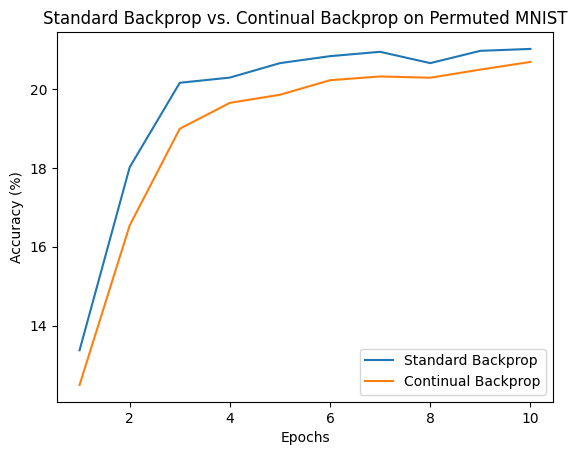

In [13]:
import random

# Function to permute MNIST images
def permute_mnist(images):
    perm = torch.randperm(28 * 28)
    images = images.view(-1, 28 * 28)
    images = images[:, perm]
    return images.view(-1, 1, 28, 28)

# Modified training function for non-stationary environment
def train_permuted(model, criterion, optimizer, epochs=20, use_continual=False):
    model.train()
    accuracy_list = []
    replacement_rate = 0.4 if use_continual else 0
    maturity_threshold = 1

    utility1, utility2 = torch.zeros(256), torch.zeros(128)
    age1, age2 = torch.zeros(256), torch.zeros(128)

    def replace_features(layer, utility, age, num_replacements):
        lowest_util_indices = utility.argsort()[:num_replacements]
        for i in lowest_util_indices:
            layer.weight.data[i, :] = torch.randn(layer.weight.shape[1]) * 0.01
            utility[i] = 0
            age[i] = 0

    for epoch in range(epochs):
        total, correct = 0, 0

        # Apply permutation at the start of each epoch to simulate non-stationarity
        for images, labels in train_loader:
            images = permute_mnist(images)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if use_continual:
                hidden_output1 = torch.relu(model.fc1(images.view(-1, 28 * 28)))
                hidden_output2 = torch.relu(model.fc2(hidden_output1))
                utility1 += torch.abs(hidden_output1.mean(dim=0))
                utility2 += torch.abs(hidden_output2.mean(dim=0))
                age1 += 1
                age2 += 1

        # For continual backprop, replace features periodically
        if use_continual and epoch % maturity_threshold == 0:
            replace_features(model.fc1, utility1, age1, int(replacement_rate * 256))
            replace_features(model.fc2, utility2, age2, int(replacement_rate * 128))

        accuracy = 100 * correct / total
        accuracy_list.append(accuracy)
        print(f'Epoch [{epoch+1}/{epochs}], Accuracy: {accuracy:.2f}%')
    return accuracy_list

# Initialize models, criterion, and optimizer
model_standard = SimpleNet()
model_continual = SimpleNet()
criterion = nn.CrossEntropyLoss()
optimizer_standard = optim.SGD(model_standard.parameters(), lr=0.01)
optimizer_continual = optim.SGD(model_continual.parameters(), lr=0.01)

# Train both models with permuted MNIST
print("Training standard backprop model on Permuted MNIST:")
acc_standard = train_permuted(model_standard, criterion, optimizer_standard, epochs=10, use_continual=False)

print("\nTraining continual backprop model on Permuted MNIST:")
acc_continual = train_permuted(model_continual, criterion, optimizer_continual, epochs=10, use_continual=True)

# Plot the results
plt.plot(range(1, 11), acc_standard, label='Standard Backprop')
plt.plot(range(1, 11), acc_continual, label='Continual Backprop')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Standard Backprop vs. Continual Backprop on Permuted MNIST')
plt.legend()
plt.show()


Training standard backprop model on Rotating MNIST:
Epoch [1/10], Accuracy: 74.20%
Epoch [2/10], Accuracy: 87.82%
Epoch [3/10], Accuracy: 88.55%
Epoch [4/10], Accuracy: 88.54%
Epoch [5/10], Accuracy: 89.26%
Epoch [6/10], Accuracy: 89.80%
Epoch [7/10], Accuracy: 90.16%
Epoch [8/10], Accuracy: 90.54%
Epoch [9/10], Accuracy: 90.95%
Epoch [10/10], Accuracy: 90.77%

Training continual backprop model on Rotating MNIST:
Epoch [1/10], Accuracy: 73.74%
Epoch [2/10], Accuracy: 87.72%
Epoch [3/10], Accuracy: 88.13%
Epoch [4/10], Accuracy: 88.26%
Epoch [5/10], Accuracy: 89.24%
Epoch [6/10], Accuracy: 89.58%
Epoch [7/10], Accuracy: 89.97%
Epoch [8/10], Accuracy: 90.28%
Epoch [9/10], Accuracy: 90.61%
Epoch [10/10], Accuracy: 90.66%


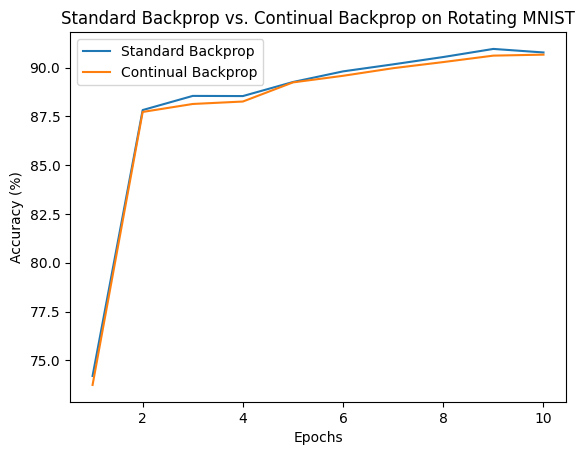

In [14]:
from torchvision.transforms.functional import rotate

# Function to rotate MNIST images
def rotate_mnist(images, angle):
    return rotate(images, angle)

# Modified training function for rotating MNIST
def train_rotating(model, criterion, optimizer, epochs=10, use_continual=False, rotation_step=15):
    model.train()
    accuracy_list = []
    replacement_rate = 0.4 if use_continual else 0
    maturity_threshold = 1

    utility1, utility2 = torch.zeros(256), torch.zeros(128)
    age1, age2 = torch.zeros(256), torch.zeros(128)

    def replace_features(layer, utility, age, num_replacements):
        lowest_util_indices = utility.argsort()[:num_replacements]
        for i in lowest_util_indices:
            layer.weight.data[i, :] = torch.randn(layer.weight.shape[1]) * 0.01
            utility[i] = 0
            age[i] = 0

    for epoch in range(epochs):
        total, correct = 0, 0
        angle = epoch * rotation_step  # Increment angle each epoch

        for images, labels in train_loader:
            images = rotate_mnist(images, angle)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if use_continual:
                hidden_output1 = torch.relu(model.fc1(images.view(-1, 28 * 28)))
                hidden_output2 = torch.relu(model.fc2(hidden_output1))
                utility1 += torch.abs(hidden_output1.mean(dim=0))
                utility2 += torch.abs(hidden_output2.mean(dim=0))
                age1 += 1
                age2 += 1

        # Replace low-utility features for continual backprop
        if use_continual and epoch % maturity_threshold == 0:
            replace_features(model.fc1, utility1, age1, int(replacement_rate * 256))
            replace_features(model.fc2, utility2, age2, int(replacement_rate * 128))

        accuracy = 100 * correct / total
        accuracy_list.append(accuracy)
        print(f'Epoch [{epoch+1}/{epochs}], Accuracy: {accuracy:.2f}%')
    return accuracy_list

# Initialize models, criterion, and optimizer
model_standard = SimpleNet()
model_continual = SimpleNet()
criterion = nn.CrossEntropyLoss()
optimizer_standard = optim.SGD(model_standard.parameters(), lr=0.01)
optimizer_continual = optim.SGD(model_continual.parameters(), lr=0.01)

# Train both models with rotating MNIST
print("Training standard backprop model on Rotating MNIST:")
acc_standard = train_rotating(model_standard, criterion, optimizer_standard, epochs=10, use_continual=False)

print("\nTraining continual backprop model on Rotating MNIST:")
acc_continual = train_rotating(model_continual, criterion, optimizer_continual, epochs=10, use_continual=True)

# Plot the results
plt.plot(range(1, 11), acc_standard, label='Standard Backprop')
plt.plot(range(1, 11), acc_continual, label='Continual Backprop')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Standard Backprop vs. Continual Backprop on Rotating MNIST')
plt.legend()
plt.show()
